# Automatic Attendance System using Face Detection
### BSEF21M506 
### BSEF21M531


In [1]:
import dlib               # pre-trained model (3 million faces)
import face_recognition   # wrapper library




import numpy as np   # numpy
import cv2           # open images/camera/window
import os            # navigate dataset directories
from statistics import mode # Pick highest frequency matches
import pandas as pd               # manipulate attendance file
from datetime import date         # add/match attend. file header
%matplotlib inline                           
from matplotlib import pyplot as plt         # Display test/train images
from IPython.display import clear_output     # Display marked attendance

2024-07-13 19:03:12.581837: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-13 19:03:12.768053: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-13 19:03:13.549890: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-13 19:03:15.641932: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### dlib detector

In [2]:
def detectDlib(img):
    boxes = face_recognition.face_locations(img, model="hog") #"cnn"
    encodings = face_recognition.face_encodings(img, boxes)
    # print(encodings)
    return  boxes, encodings 

# Creating a student database

## load data

In [3]:
dataset = "pucit"
Trn_path = "DataSets/"+dataset+"/train/"
Val_path = "DataSets/"+dataset+"/val/"
Tst_path = "DataSets/"+dataset+"/test.jpg" #image contain the faces of multiple students that are in taining data set  ,and some unknown students ,and we have labled which student in this image are in our data set



### new images

In [4]:
imagePaths = [root+'/'+name for root, dirs, files in os.walk(Trn_path) for name in files]

images = [ cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in imagePaths]


Trn_names=list()
Trn_encodings=list()   

for i, img in enumerate(images):           
    _,e = detectDlib(img)      
    if len(e)!=0:               
        Trn_names.append(  imagePaths[i].split("/")[-2]  ) 
        
        Trn_encodings.append(e[0])

['DataSets/pucit/train/507/507 (1).png', 'DataSets/pucit/train/507/507 (5).png', 'DataSets/pucit/train/507/507 (6).png', 'DataSets/pucit/train/507/507 (3).png', 'DataSets/pucit/train/507/507 (4).png', 'DataSets/pucit/train/507/507 (2).png', 'DataSets/pucit/train/502/502 (5).png', 'DataSets/pucit/train/502/502 (2).png', 'DataSets/pucit/train/502/502 (4).png', 'DataSets/pucit/train/502/502 (1).png', 'DataSets/pucit/train/502/502 (7).png', 'DataSets/pucit/train/502/502 (3).png', 'DataSets/pucit/train/502/502 (6).png', 'DataSets/pucit/train/505/505 (5).png', 'DataSets/pucit/train/505/505 (1).png', 'DataSets/pucit/train/505/505 (9).png', 'DataSets/pucit/train/505/505 (4).png', 'DataSets/pucit/train/505/505 (3).png', 'DataSets/pucit/train/505/505 (7).png', 'DataSets/pucit/train/505/505 (2).png', 'DataSets/pucit/train/505/505 (6).png', 'DataSets/pucit/train/505/505 (8).png', 'DataSets/pucit/train/506/506 (4).png', 'DataSets/pucit/train/506/506 (1).png', 'DataSets/pucit/train/506/506 (5).png',

#### save new data

In [5]:
data_frame_for_train = pd.DataFrame({'Names':Trn_names,'Data':Trn_encodings})

data_frame_for_train.to_pickle('DataSets/'+dataset+'/pretrained.pickle')

### old data

In [6]:
dat = pd.read_pickle('DataSets/'+dataset+'/pretrained.pickle')
Trn_encodings = (dat['Data']).tolist()
Trn_names = dat['Names'].tolist()

### new attendance file (csv)

In [7]:
from datetime import datetime, timedelta

# attendance file
attendance_filepath = 'DataSets/'+dataset+'/'+dataset+'_attendance.csv' 

if  not os.path.isfile(attendance_filepath):
    pd.DataFrame(sorted(set(Trn_names)), columns=['Names']).to_csv(attendance_filepath, index = False)
    # Display the content of the CSV file
attendance_df = pd.read_csv(attendance_filepath)


 


## show students (Training)

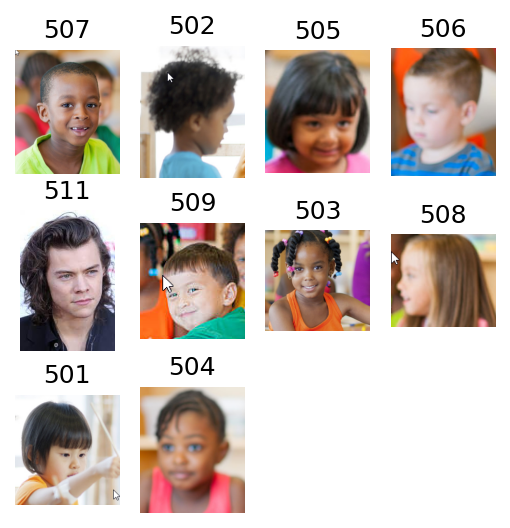

In [8]:
grid = int(np.ceil(np.sqrt(len(set(Trn_names)))))
_=plt.figure(dpi=150), [[plt.subplot(grid,grid,i+1),plt.imshow(cv2.cvtColor(cv2.imread(Trn_path+dirc+"/"+os.listdir(Trn_path+dirc)[0]), cv2.COLOR_BGR2RGB)),plt.axis("off"),plt.title(dirc),plt.subplots_adjust(left=0.0, right=0.5, bottom=0.0, top=0.9)] for i, dirc in enumerate(os.listdir(Trn_path))]

In [9]:
def _MOST_LIKELY_NAME(names_list, faces_list, face, tolerance=0.6):
    names, scores = np.array(names_list), np.linalg.norm(faces_list - face, axis=1)
    
    # sum by grouping (like sql)
    dic = {}
    for n in set(names_list):
     dic[n] = sum(scores[names==n]) / sum(names==n)
        
        
    selected_name = min(dic, key=dic.get)
    return selected_name if dic[selected_name]  < tolerance else "outsider"

In [10]:
def analyseImage(img):
    boxes, Tst_encodings = detectDlib(img)
    attendees = set()
    
    for i in range(len(boxes)):
        img = cv2.rectangle(img, (boxes[i][3], boxes[i][0]), (boxes[i][1], boxes[i][2]), (239, 62, 91), 4)

        
        name = _MOST_LIKELY_NAME(Trn_names, Trn_encodings,Tst_encodings[i])
        img = cv2.putText(img, name, (boxes[i][3], boxes[i][0]-15), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (239, 62, 91), 4)
        attendees.add(name)
        
    return img, attendees

# Launch

###  Update attendance file (csv)

In [11]:
def update_attendance_file(filepath,attendees):
    prev_att_data = pd.read_csv(filepath, dtype=str)

    for n in attendees:          
        prev_att_data.loc[prev_att_data.Names==n , str(date.today())] = 'P' # if date doesnot match, new column added aut
    prev_att_data.to_csv(filepath,index=False) 

### Validation


In [12]:
# Validation

val_imagePaths = [root+'/'+name for root, dirs, files in os.walk(Val_path) for name in files]
val_images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in val_imagePaths]
val_names = [path.split('/')[-2] for path in val_imagePaths]

correct = 0
total = len(val_images)

for i, img in enumerate(val_images):
    _, val_encodings = detectDlib(img)
    if len(val_encodings) != 0:
        name = _MOST_LIKELY_NAME(Trn_names, Trn_encodings, val_encodings[0])
        if name == val_names[i]:
            correct += 1


accuracy=correct/total
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Validation Accuracy: 100.00%


### Test on Image

['501', '502', '503', '504', '506', '508', '509']


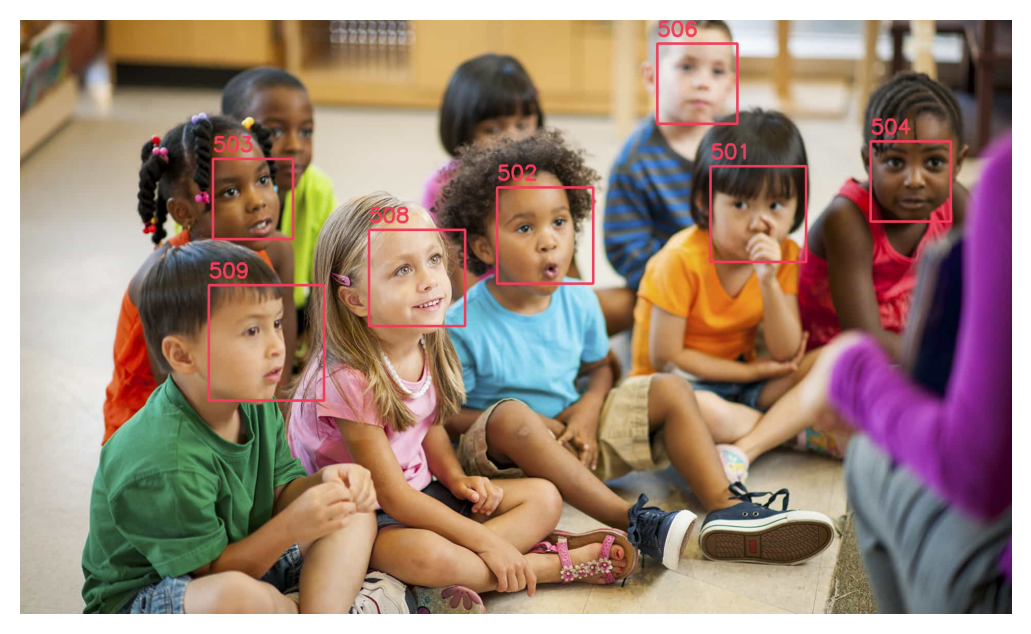

In [13]:
#preschool

Tst_img  = cv2.cvtColor(cv2.imread(Tst_path), cv2.COLOR_BGR2RGB)

Tst_img, attendd = analyseImage(Tst_img)

_ = plt.figure(dpi=200), plt.imshow(Tst_img), plt.axis("off")
print(sorted(attendd))

update_attendance_file('DataSets/'+dataset+'/'+dataset+'_attendance.csv' , attendd )



In [14]:
# Define the ground truth attendance for the test image
ground_truth_attendance = ['501', '502', '503', '504', '506', '508', '509']

# Convert attendd set to a sorted list
predicted_attendance = sorted(list(attendd))

# Compute accuracy
correct_predictions = len(set(ground_truth_attendance) & set(predicted_attendance))
total_predictions = len(ground_truth_attendance)
accuracy = (correct_predictions / total_predictions) * 100

print(f"Predicted Attendance: {predicted_attendance}")
print(f"Ground Truth Attendance: {ground_truth_attendance}")
print(f"Accuracy: {accuracy:.2f}%")


Predicted Attendance: ['501', '502', '503', '504', '506', '508', '509']
Ground Truth Attendance: ['501', '502', '503', '504', '506', '508', '509']
Accuracy: 100.00%


### -- Test on video/cam

In [15]:
cap = cv2.VideoCapture(0)
attendance = set()

while(True):
    ret, frame = cap.read()
    
    frame, att = analyseImage(frame)
    attendance = attendance.union(att)
    
    cv2.imshow('Live Attendance', frame )
    clear_output(wait=True)
    print(sorted(attendance))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

update_attendance_file('DataSets/'+dataset+'/'+dataset+'_attendance.csv' , attendance )

['outsider']
